In [1]:
print("sgn")

sgn


In [2]:
!pip install qiskit
!pip install qiskit-aer
!pip install pylatexenc
!pip install qiskit-ibm-runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=47a7cbf757d7edcd4ef665c93e74f93e9870a5f32ce6319e3cc87d9cfe001aef
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import qiskit

In [4]:
!pip freeze | grep qiskit

qiskit==2.0.0
qiskit-aer==0.17.0
qiskit-ibm-runtime==0.37.0


In [5]:
def get_statevector( qc, state_name = "state"):
  qcm = qc.copy()
  qcm.save_state(state_name)
  # Use statevector simulator to inspect the state
  simulator = AerSimulator(method="statevector")
  compiled_circ = transpile(qcm, simulator)
  result = simulator.run(compiled_circ).result()
  state = result.data()[state_name]
  return state, compiled_circ

def initialize_problem( A, b ):
  norm_b = np.linalg.norm(b)
  b_normalized = b / norm_b
  return A, b_normalized

def initialize_circuit(b_normalized):
  q_system = QuantumRegister(1, 'system')
  q_phase  = QuantumRegister(3, 'phase')
  q_anc    = QuantumRegister(1, 'ancilla')
  qc = QuantumCircuit(q_system, q_phase, q_anc)
  qc.initialize(b_normalized, q_system[0])
  return q_system, q_phase, q_anc, qc

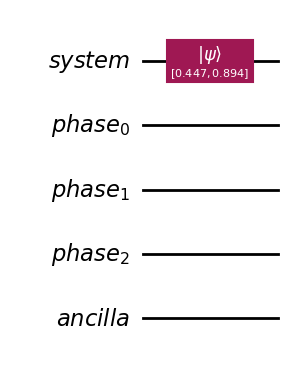

In [7]:
import numpy as np
import math
from scipy.linalg import expm
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit.circuit.library import UnitaryGate, QFT, RYGate
# =============================================================================
# Define the linear system: A x = b
# =============================================================================
A = np.array([[1, -2],
              [-2,  1]])
b = np.array([2, 4])
# Normalize b (note: in the HHL algorithm we encode |b⟩)
A, b_normalized = initialize_problem( A, b )

# =============================================================================
# Create quantum registers:
#   - 1 qubit for the system (to encode |b⟩)
#   - 3 qubits for phase estimation (increased precision)
#   - 1 ancilla qubit for controlled rotation
# =============================================================================
q_system, q_phase, q_anc, qc = initialize_circuit(b_normalized)
qc.draw(output="mpl")

In [8]:
ori = [ -10/3, -8/3 ]
ori = ori / np.linalg.norm(ori)
print( "Original Solution : ")
ori

Original Solution : 


array([-0.78086881, -0.62469505])

In [9]:
get_statevector(qc)

(Statevector([0.4472136 +0.j, 0.89442719+0.j, 0.        +0.j,
              0.        +0.j, 0.        +0.j, 0.        +0.j,
              0.        +0.j, 0.        +0.j, 0.        +0.j,
              0.        +0.j, 0.        +0.j, 0.        +0.j,
              0.        +0.j, 0.        +0.j, 0.        +0.j,
              0.        +0.j, 0.        +0.j, 0.        +0.j,
              0.        +0.j, 0.        +0.j, 0.        +0.j,
              0.        +0.j, 0.        +0.j, 0.        +0.j,
              0.        +0.j, 0.        +0.j, 0.        +0.j,
              0.        +0.j, 0.        +0.j, 0.        +0.j,
              0.        +0.j, 0.        +0.j],
             dims=(2, 2, 2, 2, 2)),
 <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7b7bee9637d0>)


==== Step 2: Phase Estimation (QPE) with 3 qubits ====


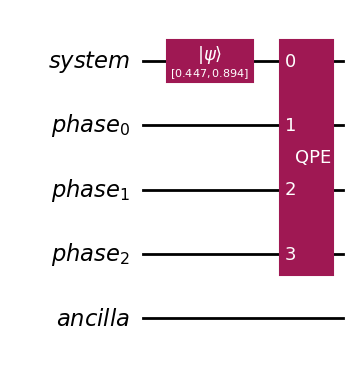

In [10]:
# =============================================================================
# STEP 2: Phase Estimation (QPE) with 3 qubits
# =============================================================================
# Build a QPE subcircuit. Here we use t = 1.
qpe = QuantumCircuit(q_system, q_phase, name="QPE")
qpe.h(q_phase)  # Hadamard on all 3 phase qubits

# We now apply controlled-U^(2^(n-1-j)) for j = 0,1,2 (n=3).
# That is:
#   For j=0 (most significant): exponent = 2^(2)=4
#   For j=1: exponent = 2^(1)=2
#   For j=2 (least significant): exponent = 2^(0)=1
U_4 = expm(1j * 4 * A)  # U^(4)
U_2 = expm(1j * 2 * A)  # U^(2)
U_1 = expm(1j * A)      # U^(1)

cU_4 = UnitaryGate(U_4, label="exp(i4A)").control(1)
cU_2 = UnitaryGate(U_2, label="exp(i2A)").control(1)
cU_1 = UnitaryGate(U_1, label="exp(iA)").control(1)

# Apply controlled unitaries:
# Here we assume q_phase[0] is the most significant qubit.
qpe.append(cU_4, [q_phase[0], q_system[0]])
qpe.append(cU_2, [q_phase[1], q_system[0]])
qpe.append(cU_1, [q_phase[2], q_system[0]])

# Apply the inverse QFT on the 3–qubit phase register.
# We'll use Qiskit's QFT with inverse=True and do_swaps=True.
qft_dagger = QFT(3, inverse=True, do_swaps=True)
qpe.append(qft_dagger.to_instruction(), q_phase[:])
# Append the QPE subcircuit to the main circuit.
qc.append(qpe.to_instruction(), q_system[:] + q_phase[:])
print("\n==== Step 2: Phase Estimation (QPE) with 3 qubits ====")
qc.draw(output='mpl')

In [11]:
state, cc = get_statevector(qc)

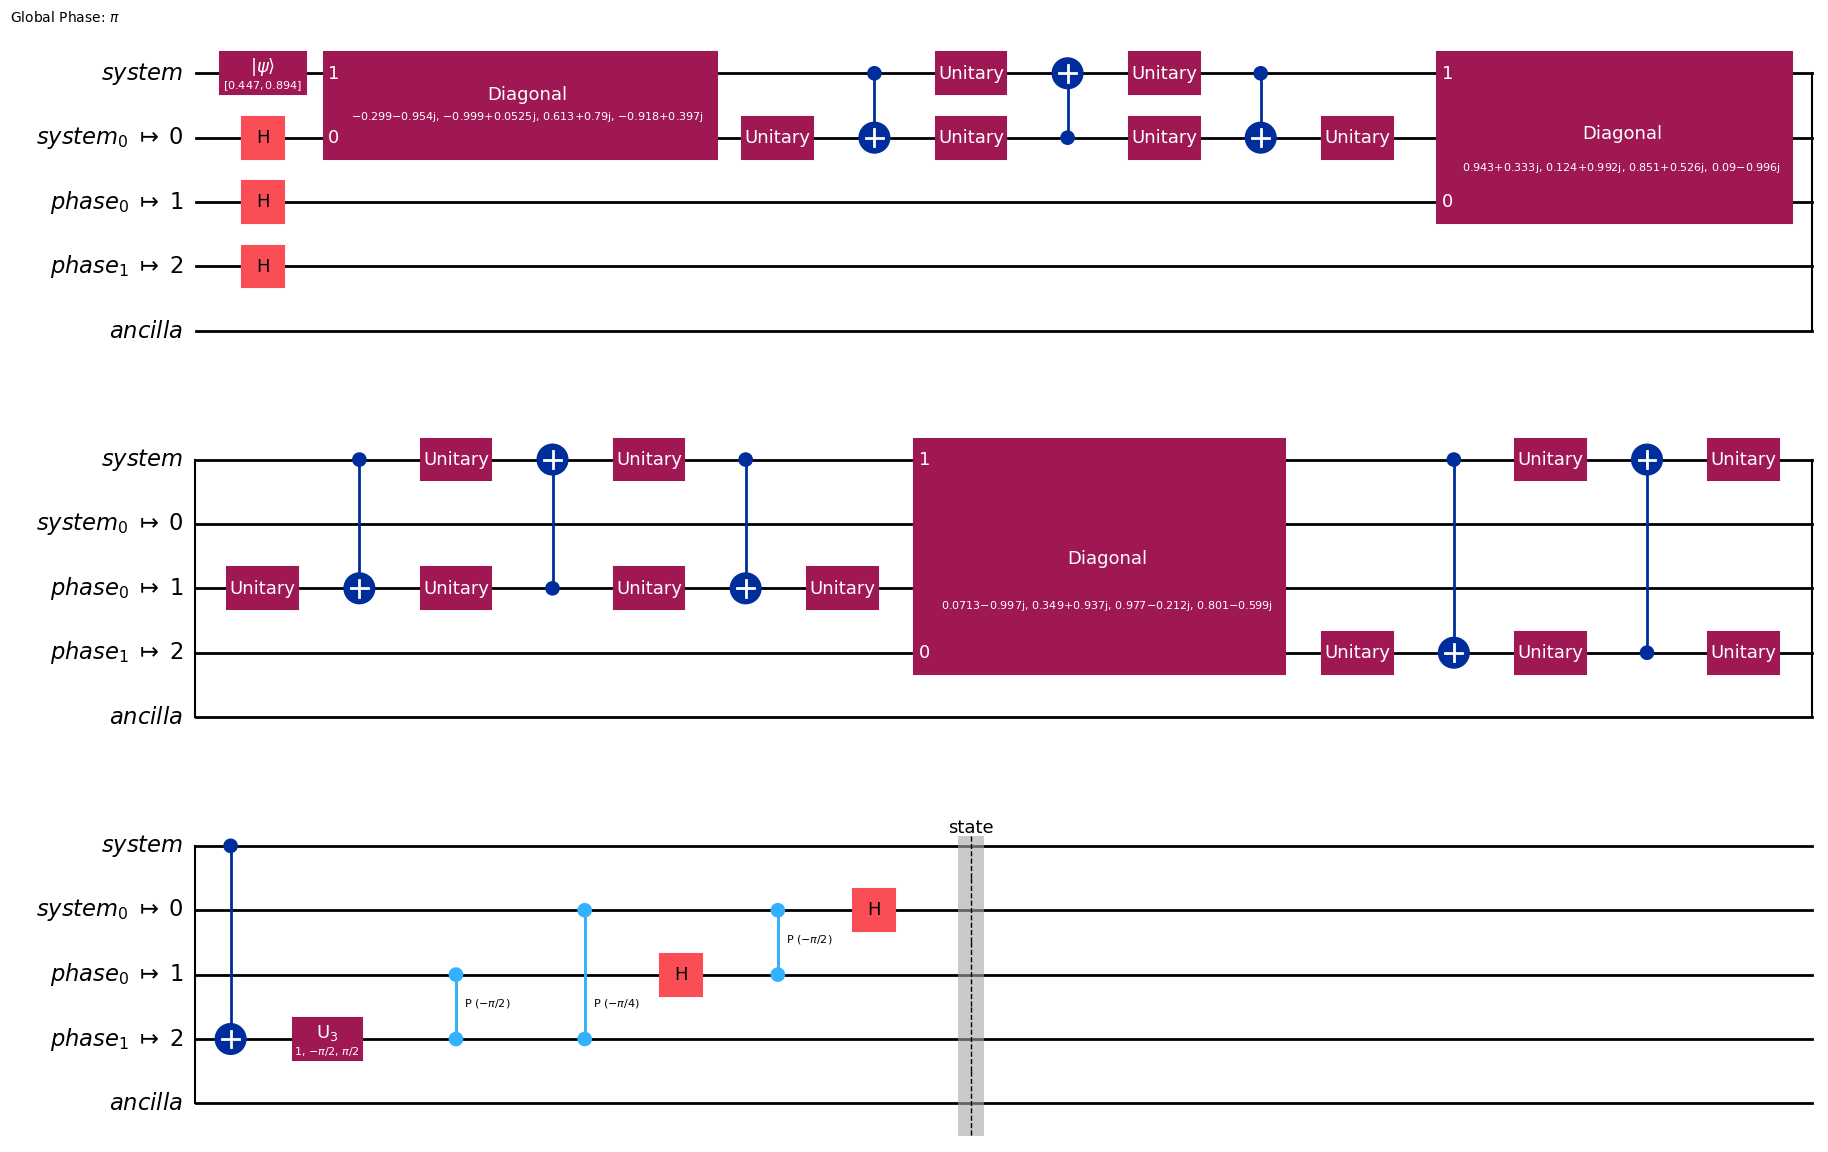

In [12]:
cc.draw(output='mpl')


==== Step 3: Controlled Rotation ====


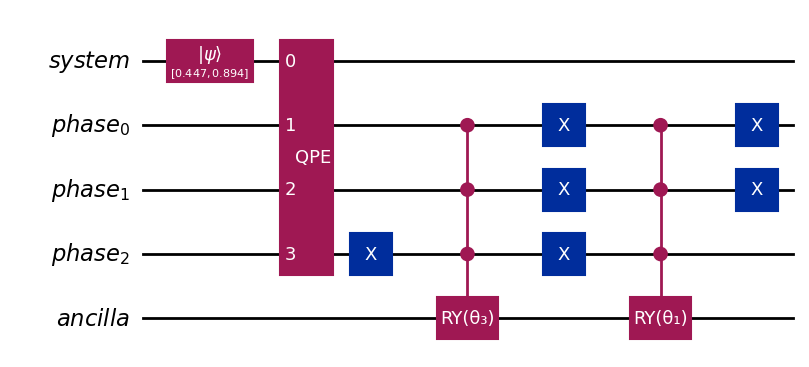

In [13]:

# =============================================================================
# STEP 3: Controlled Rotation on the Ancilla
# =============================================================================
# Here we add controlled rotations on the ancilla qubit conditioned on the phase register
# indicating a particular eigenvalue estimate.
# We assume two branches:
#   (a) For eigenvalue 3: phase register is assumed to yield |110⟩.
#       For lambda = 3, use theta_3 = 2 * arcsin(1/3).
#   (b) For eigenvalue -1: phase register is assumed to yield |001⟩.
#       For lambda = 1 (absolute value of -1), use theta_1 = 2 * arcsin(1/1) = π.
theta_3 = 2 * np.arcsin(1/3)
theta_1 = np.pi

# --- Branch for eigenvalue 3 (expected phase = |110⟩) ---
# The condition |110⟩ means: phase[0] = 1, phase[1] = 1, phase[2] = 0.
# Standard multi–controlled gates trigger when all controls are |1⟩.
# So, for the branch |110⟩, we flip the qubit that should be 0 (q_phase[2]) before and after.
rot_3 = QuantumCircuit(1)
rot_3.ry(theta_3, 0)
rot_3_gate = rot_3.to_gate()
rot_3_gate.label = "RY(θ₃)"
# Create a 3–controlled version (controls on all three phase qubits)
cry_3 = rot_3_gate.control(3)
# Flip q_phase[2] (least significant) so that the control condition becomes |110⟩
qc.x(q_phase[2])
qc.append(cry_3, q_phase[:] + [q_anc[0]])
qc.x(q_phase[2])

# --- Branch for eigenvalue -1 (expected phase = |001⟩) ---
# The condition |001⟩ means: phase[0] = 0, phase[1] = 0, phase[2] = 1.
# For controls to trigger on 0, we flip those qubits.
rot_1 = QuantumCircuit(1)
rot_1.ry(theta_1, 0)
rot_1_gate = rot_1.to_gate()
rot_1_gate.label = "RY(θ₁)"
cry_1 = rot_1_gate.control(3)
# Flip phase[0] and phase[1] so that the condition becomes |1,1,1⟩ (which is our controlled condition)
qc.x(q_phase[0])
qc.x(q_phase[1])
qc.append(cry_1, q_phase[:] + [q_anc[0]])
qc.x(q_phase[0])
qc.x(q_phase[1])
print("\n==== Step 3: Controlled Rotation ====")
qc.draw(output='mpl')


==== Step 4: Uncompute Phase Estimation ====


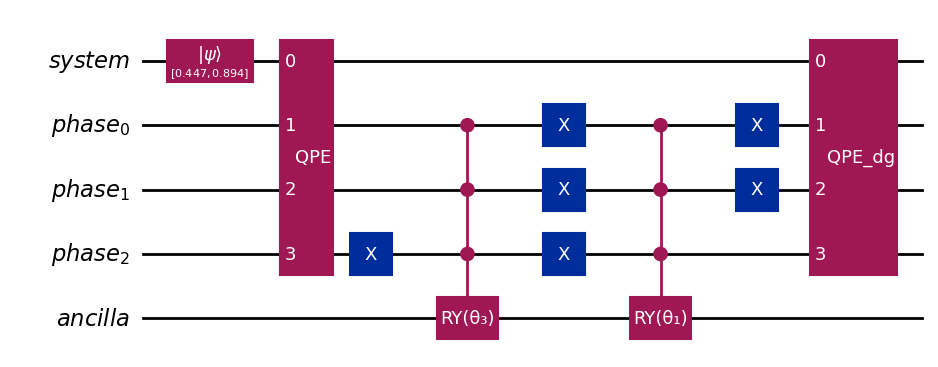

In [14]:

# =============================================================================
# STEP 4: Uncompute Phase Estimation (Inverse QPE)
# =============================================================================
# Uncompute the phase estimation by applying the inverse of the QPE subcircuit.
qpe_inv = qpe.inverse()
qc.append(qpe_inv.to_instruction(), q_system[:] + q_phase[:])
print("\n==== Step 4: Uncompute Phase Estimation ====")
qc.draw(output='mpl')




In [15]:

# =============================================================================
# STEP 5: Measurement and Histogram
# =============================================================================
# In the HHL algorithm one post–selects on the ancilla qubit being |1⟩.
# Here, for demonstration, we copy the circuit and add measurements.
qc_measure = qc.copy()
qc_measure.measure_all()

# Use a density matrix simulator for measurement outcomes.
simulator_measure = AerSimulator(method="density_matrix")
compiled_circ_measure = transpile(qc_measure, simulator_measure)
result_measure = simulator_measure.run(compiled_circ_measure, shots = 2048).result()
counts = result_measure.get_counts(qc_measure)
print("\nMeasurement counts:")
print(counts)
qc_measure.draw(output='mpl')
plot_histogram(counts)
# =============================================================================
# STEP 6: Compute the Proportional System State from Post-Selected Outcomes
# =============================================================================
def compute_proportional_state(counts):
    """
    Given a dictionary 'counts' where keys are 5-bit strings in the order:
    [ancilla, phase2, phase1, phase0, system]
    Filter for outcomes with ancilla = '1' and phase register = '000'
    (i.e. post-selected for successful uncomputation).
    Then compute and return the proportional state vector of the system qubit.
    """
    # Filter: ancilla must be '1' and phase bits (next 3 bits) must be '000'
    filtered_counts = { key: val for key, val in counts.items() if key[0]=='1' and key[1:4]=='000' }

    # Sum counts for system qubit outcomes (last bit)
    count_0 = sum(val for key, val in filtered_counts.items() if key[-1]=='0')
    count_1 = sum(val for key, val in filtered_counts.items() if key[-1]=='1')
    total = count_0 + count_1
    if total == 0:
        raise ValueError("No successful post-selected outcomes (ancilla=1, phase=000) found.")

    p0 = count_0 / total
    p1 = count_1 / total

    # Amplitudes are square roots (up to global phase)
    amp0 = np.sqrt(p0)
    amp1 = np.sqrt(p1)
    state = np.array([amp0, amp1])
    # Normalize (should be normalized if p0+p1=1)
    return state / np.linalg.norm(state)

# Compute the proportional system state from measurement counts.
proportional_state = compute_proportional_state(counts)
print("\nProportional system state |x⟩ (up to normalization):")
print(proportional_state)



Measurement counts:
{'01101': 26, '00100': 77, '10010': 6, '10101': 87, '00110': 12, '00001': 1211, '11100': 9, '01000': 5, '01100': 25, '10111': 16, '10100': 79, '10001': 61, '00101': 80, '01001': 7, '11010': 3, '10110': 27, '11001': 1, '00000': 189, '10000': 60, '00111': 14, '00011': 4, '01111': 7, '11110': 6, '01110': 4, '10011': 8, '01010': 1, '11101': 10, '11011': 2, '11111': 4, '00010': 7}

Proportional system state |x⟩ (up to normalization):
[0.70417879 0.7100227 ]


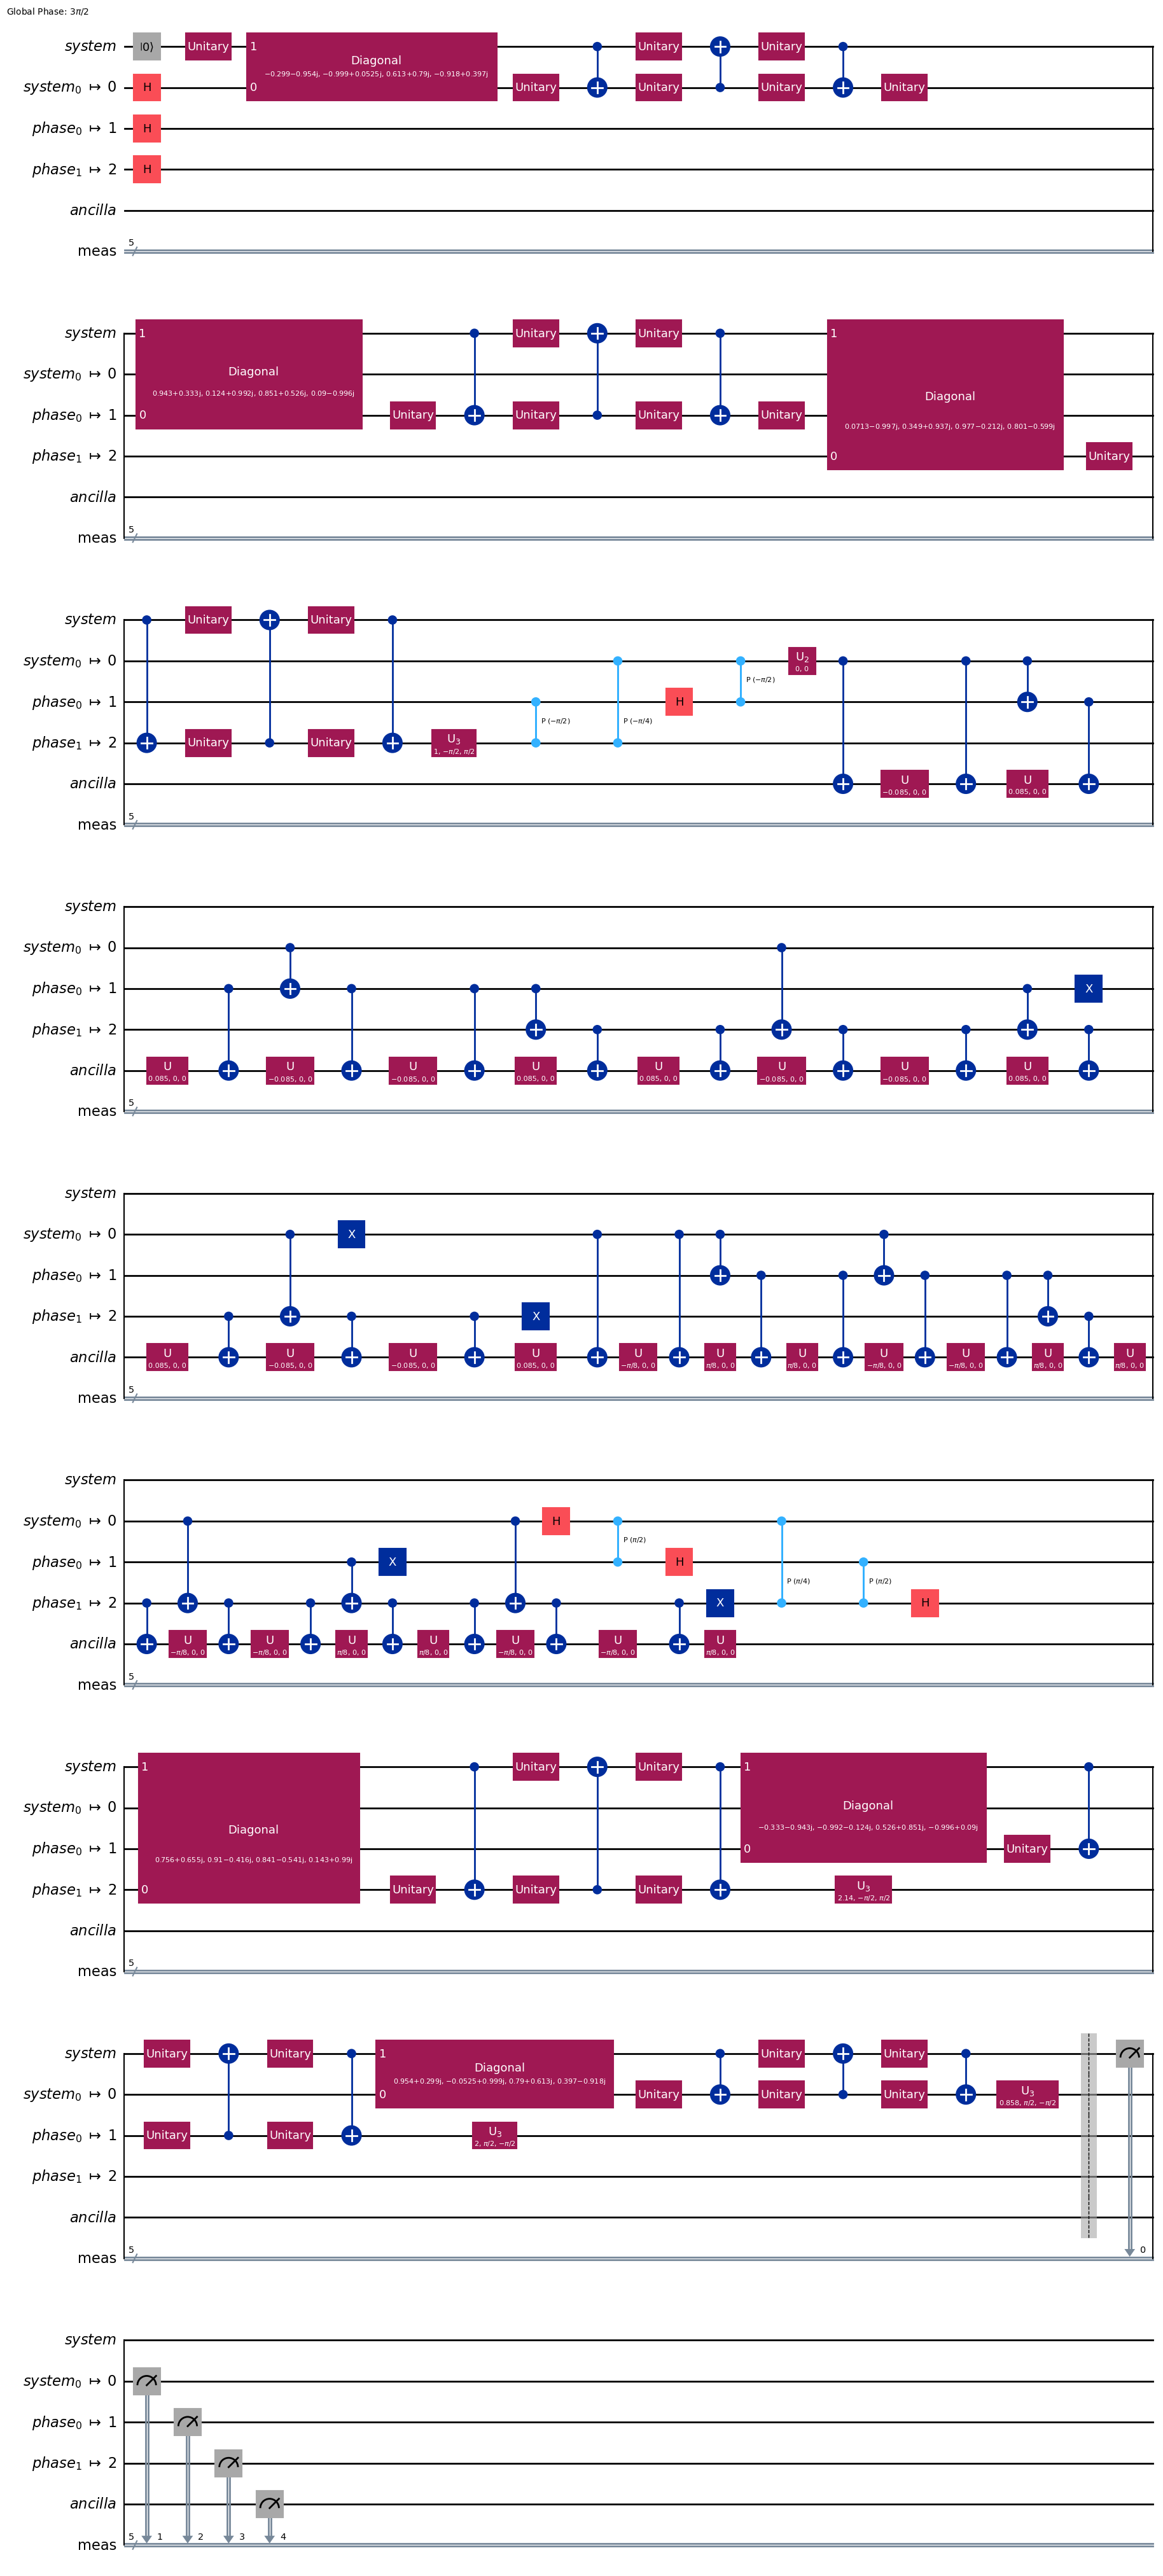

In [17]:
compiled_circ_measure.draw(output='mpl')

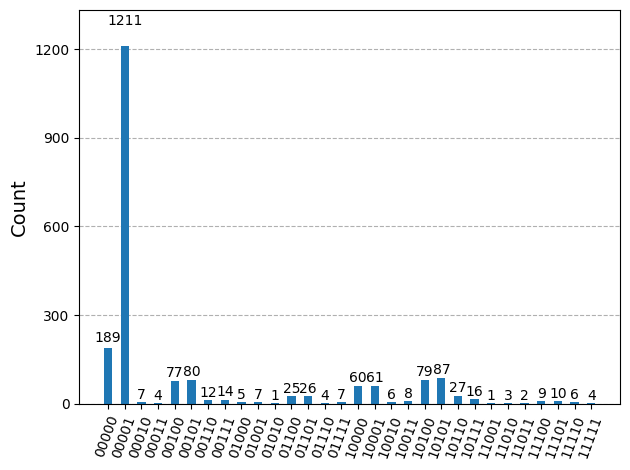

In [16]:

plot_histogram(counts)

#Running On Actual Quantum Hardware

In [ ]:
token = "084a18465b483541fbffee9d8ccb26405d7ebdaeed4d18fe4f3b9f9193ed2b81193509e141bee54613b0728bf45541ab47c59f1e17f4836bea95e976cc602be3"

In [ ]:
import time

def simple_job_monitor(job, poll_interval=10):
    print("Job ID:", job.job_id())
    while not job.status().is_final():
        print("Current status:", job.status())
        time.sleep(poll_interval)
    print("Final status:", job.status())

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)

In [ ]:
# =============================================================================
# STEP 5: Measurement and Submission to Hardware using Sampler
# =============================================================================
# Create a copy for measurement.
qc_measure = qc.copy()
qc_measure.measure_all()
print("\n==== Final Measured Circuit ====")
print(qc_measure.draw(output='text'))

# Now, instead of using AerSimulator, we use Qiskit IBM Runtime’s Sampler.
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Load your IBM Quantum account (ensure you have saved your API token previously)
service = QiskitRuntimeService()

# Choose a hardware backend—here we select the least busy hardware.
backend = service.least_busy(operational=True, simulator=False)
#print("Selected backend:", backend.name())

pm = generate_preset_pass_manager(backend=backend)
isa_circuit = pm.run(qc_measure)

# Create the Sampler instance using the hardware backend.
sampler = Sampler(mode=backend)
sampler.options.default_shots = 1024  # Set the number of shots as desired.

# Run the measured circuit on hardware.
job = sampler.run([isa_circuit])
print(f"Job ID: {job.job_id()}")

# Wait for the job to finish and get the results.
result = job.result()[0]
counts = result.data.meas.get_counts()
print("\nMeasurement counts:")
print(counts)

# Plot histogram of the measurement outcomes.
plot_histogram(counts)
# =============================================================================
# STEP 6: Compute the Proportional System State from Post-Selected Outcomes
# =============================================================================
def compute_proportional_state(counts):
    """
    Given a dictionary 'counts' where keys are 5-bit strings in the order:
    [ancilla, phase2, phase1, phase0, system],
    filter for outcomes with ancilla = '1' and phase register = '000'
    (i.e. post-selected for successful uncomputation).
    Then compute and return the proportional state vector of the system qubit.
    """
    filtered_counts = { key: val for key, val in counts.items() if key[0]=='1' and key[1:4]=='000' }
    count_0 = sum(val for key, val in filtered_counts.items() if key[-1]=='0')
    count_1 = sum(val for key, val in filtered_counts.items() if key[-1]=='1')
    total = count_0 + count_1
    if total == 0:
        raise ValueError("No successful post-selected outcomes (ancilla=1, phase=000) found.")
    p0 = count_0 / total
    p1 = count_1 / total
    amp0 = np.sqrt(p0)
    amp1 = np.sqrt(p1)
    state = np.array([amp0, amp1])
    return state / np.linalg.norm(state)

proportional_state = compute_proportional_state(counts)
print("\nProportional system state |x⟩ (up to normalization):")
print(proportional_state)


==== Final Measured Circuit ====
         ┌─────────────────────────────┐┌──────┐                              »
 system: ┤ Initialize(0.44721,0.89443) ├┤0     ├──────────────────────────────»
         └─────────────────────────────┘│      │               ┌───┐          »
phase_0: ───────────────────────────────┤1     ├─────────■─────┤ X ├────■─────»
                                        │  QPE │         │     ├───┤    │     »
phase_1: ───────────────────────────────┤2     ├─────────■─────┤ X ├────■─────»
                                        │      │┌───┐    │     ├───┤    │     »
phase_2: ───────────────────────────────┤3     ├┤ X ├────■─────┤ X ├────■─────»
                                        └──────┘└───┘┌───┴────┐└───┘┌───┴────┐»
ancilla: ────────────────────────────────────────────┤ RY(θ₃) ├─────┤ RY(θ₁) ├»
                                                     └────────┘     └────────┘»
 meas: 5/═════════════════════════════════════════════════════════════════════»
      

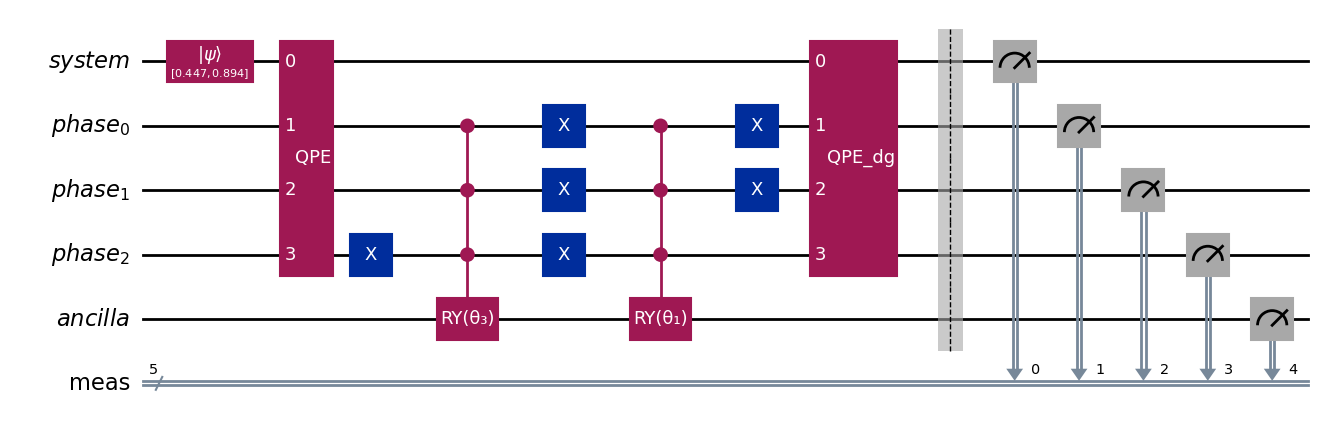

In [ ]:
qc_measure.draw(output='mpl')

In [ ]:
original = np.array([-10/3,-8/3])
original = original / np.linalg.norm(original)
original

array([-0.78086881, -0.62469505])

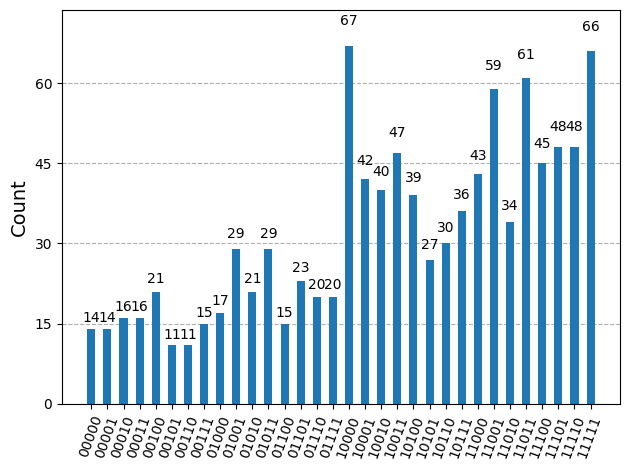

In [ ]:
plot_histogram(counts)

In [ ]:
!pip freeze | grep qiskit

qiskit==2.0.0
qiskit-aer==0.17.0
qiskit-ibm-runtime==0.37.0


In [ ]:
backend

<IBMBackend('ibm_sherbrooke')>

In [ ]:
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

service = QiskitRuntimeService()

bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)
bell.measure_all()

backend = service.least_busy(operational=True, simulator=False)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(bell)

# 3. Execute using the Sampler primitive
sampler = Sampler(mode=backend)
sampler.options.default_shots = 100000  # Options can be set using auto-complete.
job = sampler.run([isa_circuit])
print(f"Job ID is {job.job_id()}")
pub_result = job.result()[0]
print(f"Counts for the meas output register: {pub_result.data.meas.get_counts()}")

Job ID is czqhgrvd8drg008ghb00
Counts for the meas output register: {'10': 48, '00': 467, '11': 488, '01': 21}
